# Computer Vision Homework 3: Big vs Small Models

## Brief

Due date: Nov 13, 2023

Required files: `homework-3.ipynb`, `report.pdf`

To download the jupyter notebook from colab, you can refer to the colab tutorial we gave.


### Import Packages

In [ ]:
import glob
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

from PIL import Image
from torch.utils.data import DataLoader, Dataset, RandomSampler
from torchvision import transforms, models, datasets
from tqdm import tqdm

%matplotlib inline

In [ ]:
from torch.utils.tensorboard import SummaryWriter
os.system('rm -r runs')
print('removing previos run dir')
writer = SummaryWriter()

removing previos run dir


### Check GPU Environment

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device} device')

Using cuda device


In [ ]:
! nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-601e4631-c64c-bd06-2ab0-ba0e19916d17)


### Set the Seed to Reproduce the Result

In [ ]:
def set_all_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
set_all_seed(123)

### Create Dataset and Dataloader

In [ ]:
batch_size = 256

mean = (0.4914, 0.4822, 0.4465)
std = (0.2471, 0.2435, 0.2616)
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

train_dataset = datasets.CIFAR10(root='data', train=True, download=True, transform=train_transform)
valid_dataset = datasets.CIFAR10(root='data', train=False, download=True, transform=test_transform)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified


### Load Models

In [ ]:
# TODO: Try to achieve the best performance given all training data using whatever model and training strategy.
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnext50_32x4d', weights="IMAGENET1K_V2")

model.fc = nn.Linear(model.fc.in_features, out_features=10, bias=True)
model = model.to(device)

# print(model)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


### Training and Testing Models

In [ ]:
# TODO: Fill in the code cell according to the pytorch tutorial we gave.
def train(dataloader, model, loss_fn, optimizer):
    num_batches = len(dataloader)
    size = len(dataloader.dataset)
    epoch_loss = 0
    correct = 0

    model.train()

    for X, y in tqdm(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        pred = pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(y.view_as(pred)).sum().item()

    avg_epoch_loss = epoch_loss / num_batches
    avg_acc = correct / size

    return avg_epoch_loss, avg_acc

def test(dataloader, model, loss_fn):
    num_batches = len(dataloader)
    size = len(dataloader.dataset)
    epoch_loss = 0
    correct = 0

    model.eval()

    with torch.no_grad():
        for X, y in tqdm(dataloader):
            X, y = X.to(device), y.to(device)

            pred = model(X)

            epoch_loss += loss_fn(pred, y).item()
            pred = pred.argmax(dim=1, keepdim=True)
            correct += pred.eq(y.view_as(pred)).sum().item()

    avg_epoch_loss = epoch_loss / num_batches
    avg_acc = correct / size

    return avg_epoch_loss, avg_acc

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

epochs = 20

In [ ]:
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []
best_acc = 0

for epoch in range(epochs):
    train_loss, train_acc = train(train_dataloader, model, loss_fn, optimizer)
    test_loss, test_acc = test(valid_dataloader, model, loss_fn)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
    if test_acc > best_acc:
      best_acc = test_acc
    print(f"Epoch {epoch + 1:2d}: Loss = {train_loss:.4f} Acc = {train_acc:.2f} Test_Loss = {test_loss:.4f} Test_Acc = {test_acc:.2f}")
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Loss/test', test_loss, epoch)
    writer.add_scalar('Acc/train', train_acc, epoch)
    writer.add_scalar('Acc/test', test_acc, epoch)

writer.close()

100%|██████████| 40/40 [00:04<00:00,  8.36it/s]


Epoch  1: Loss = 0.9147 Acc = 0.69 Test_Loss = 0.5381 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 10.67it/s]


Epoch  2: Loss = 0.4812 Acc = 0.84 Test_Loss = 0.4915 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 10.42it/s]


Epoch  3: Loss = 0.4023 Acc = 0.86 Test_Loss = 0.4976 Test_Acc = 0.86


100%|██████████| 40/40 [00:04<00:00,  8.76it/s]


Epoch  4: Loss = 0.3397 Acc = 0.88 Test_Loss = 0.4275 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 10.82it/s]


Epoch  5: Loss = 0.2971 Acc = 0.90 Test_Loss = 0.3925 Test_Acc = 0.87


100%|██████████| 40/40 [00:04<00:00,  9.34it/s]


Epoch  6: Loss = 0.2784 Acc = 0.91 Test_Loss = 0.3645 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.08it/s]


Epoch  7: Loss = 0.2630 Acc = 0.91 Test_Loss = 0.4262 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 11.13it/s]


Epoch  8: Loss = 0.2809 Acc = 0.90 Test_Loss = 0.4337 Test_Acc = 0.86


100%|██████████| 40/40 [00:04<00:00,  9.75it/s]


Epoch  9: Loss = 0.2545 Acc = 0.91 Test_Loss = 0.3484 Test_Acc = 0.89


100%|██████████| 40/40 [00:03<00:00, 10.87it/s]


Epoch 10: Loss = 0.2115 Acc = 0.93 Test_Loss = 0.3504 Test_Acc = 0.89


100%|██████████| 40/40 [00:04<00:00,  8.24it/s]


Epoch 11: Loss = 0.1902 Acc = 0.93 Test_Loss = 0.3658 Test_Acc = 0.89


100%|██████████| 40/40 [00:03<00:00, 10.90it/s]


Epoch 12: Loss = 0.1727 Acc = 0.94 Test_Loss = 0.3785 Test_Acc = 0.89


100%|██████████| 40/40 [00:04<00:00,  9.13it/s]


Epoch 13: Loss = 0.1707 Acc = 0.94 Test_Loss = 0.3705 Test_Acc = 0.89


100%|██████████| 40/40 [00:03<00:00, 10.90it/s]


Epoch 14: Loss = 0.1526 Acc = 0.95 Test_Loss = 0.3803 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 10.18it/s]


Epoch 15: Loss = 0.1452 Acc = 0.95 Test_Loss = 0.3801 Test_Acc = 0.89


100%|██████████| 40/40 [00:03<00:00, 10.25it/s]


Epoch 16: Loss = 0.1394 Acc = 0.95 Test_Loss = 0.3840 Test_Acc = 0.89


100%|██████████| 40/40 [00:04<00:00,  9.91it/s]


Epoch 17: Loss = 0.1364 Acc = 0.95 Test_Loss = 0.3694 Test_Acc = 0.89


100%|██████████| 40/40 [00:04<00:00,  8.98it/s]


Epoch 18: Loss = 0.1318 Acc = 0.96 Test_Loss = 0.3931 Test_Acc = 0.89


100%|██████████| 40/40 [00:03<00:00, 10.72it/s]


Epoch 19: Loss = 0.1259 Acc = 0.96 Test_Loss = 0.4277 Test_Acc = 0.89


100%|██████████| 40/40 [00:04<00:00,  8.25it/s]

Epoch 20: Loss = 0.1172 Acc = 0.96 Test_Loss = 0.3937 Test_Acc = 0.89


In [ ]:
print(best_acc)

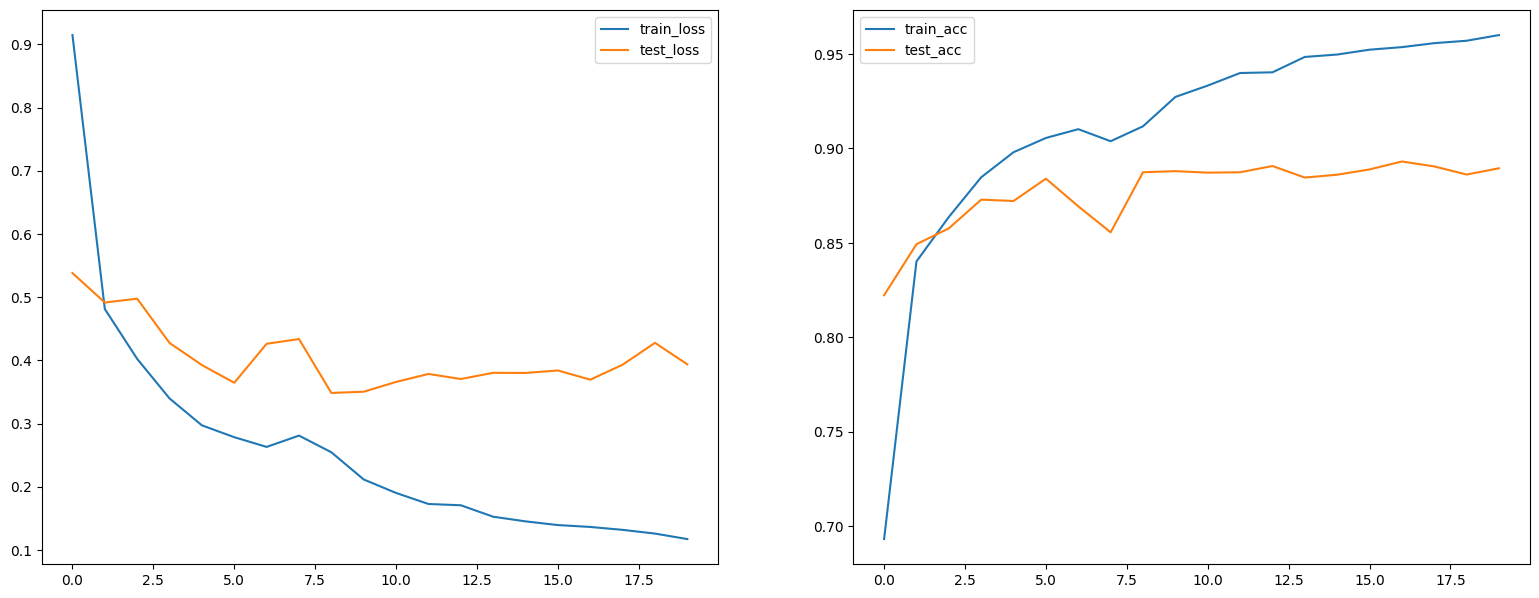

0.8931


In [ ]:
plt.figure(figsize=(19.2,7.2))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='train_loss')
plt.plot(test_loss_list, label='test_loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label='train_acc')
plt.plot(test_acc_list, label='test_acc')
plt.legend()

plt.show()

## Credits

1. [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html)